Reusing Pre-trained Sub-graph
=============================

## Problem

In [1]:
%matplotlib inline

import os
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
from tqdm import trange
from tfutils.graph import get_dependent_variables
from tfutils.train import save_variables, restore_variables

# For reproducibility
seed = 42
np.random.seed(seed)
tf.set_random_seed(seed)

For illustration, let's employ MNIST, which fastens the experiment greatly.

In [2]:
DATA_DIR = './dat/'

mnist = input_data.read_data_sets(
    os.path.join(DATA_DIR, 'MNIST'),
    one_hot=True,
    source_url='http://yann.lecun.com/exdb/mnist/')

def get_X_batch(batch_size):
    """The value of the X-batch is binary, being either `0.0` or `1.0`.
    
    Args:
        batch_size: Positive integer.
    
    Returns:
        A numpy array of the shape `[batch_size, 28*28]`.
    """
    X_batch, _ = mnist.train.next_batch(batch_size)
    X_batch = np.where(X_batch>0.5, np.ones_like(X_batch), np.zeros_like(X_batch))
    return X_batch

In [3]:
def deep_nn(inputs, units, name='deep_nn', reuse=None):
    """Builds sub-graph.
    
    Args:
        inputs: Tensor of the shape `[B, ?]`.
        units: List of positive integers.
        name: String.
        reuse: Boolean.
        
    Returns:
        Tensor of the shape `[B, units[-1]]`.
    """
    with tf.variable_scope(name, reuse=reuse):
        hidden = inputs
        for unit in units[:-1]:
            hidden = tf.layers.dense(
                hidden, unit, activation=tf.nn.relu)
        outputs = tf.layers.dense(
            hidden, units[-1], activation=None)
        return outputs

In [4]:
def smear(values, window_size):
    """Auxillary function for plotting. If the plot are bushing,
    e.g. plot of loss-values, smearing is called for.
    
    Args:
        values: List of real numbers.
        window_size: Positive integer.
    
    Returns:
        List of real numbers.
    """
    smeared = []
    for i, _ in enumerate(values):
        
        # Get values-in-window
        start_id = i + 1 - window_size
        if start_id < 0:
            start_id = 0
        end_id = i + 1
        values_in_window = values[start_id:end_id]
        
        smeared.append(np.mean(values_in_window))
    return smeared

### Simple Auto-encoder

To illustrate the problem, we first build and train a simple auto-encoder, with a `256`-dimensional latent space, and units of layers:

    28*28 -> 512 -> 256 -> 512 -> 28*28

In [5]:
tf.reset_default_graph()

In [6]:
X_ph = tf.placeholder(shape=[None, 28*28], dtype='float32', name='X')

In [7]:
encoded = deep_nn(X_ph, [512, 256], name='encoder_0')
decoded = deep_nn(encoded, [512, 28*28], name='decoder_0')

In [8]:
loss = (tf.losses.sigmoid_cross_entropy(X_ph, decoded)
        + tf.reduce_mean(tf.square(encoded)))

In [9]:
optimizer = tf.train.AdamOptimizer(epsilon=1e-3)
train_op = optimizer.minimize(loss)

In [10]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [11]:
N_ITERS = 30000
BATCH_SIZE = 128

loss_vals_0 = []

for step in trange(N_ITERS):
    X_batch = get_X_batch(BATCH_SIZE)
    _, loss_val = sess.run([train_op, loss], {X_ph: X_batch})
    loss_vals_0.append(loss_val)

100%|██████████| 30000/30000 [07:30<00:00, 66.67it/s]


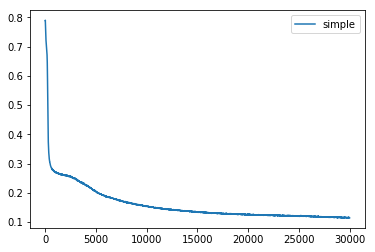

Final loss: 0.11432374


In [12]:
WINDOW_SIZE = 50

plt.plot(smear(loss_vals_0, WINDOW_SIZE), label='simple')
plt.legend()
plt.show()
print('Final loss:', np.mean(loss_vals_0[-WINDOW_SIZE:]))

The following cell is for the later usage (to be declared in the section "Stacked Auto-encoder with Pre-trained").

In [13]:
SAVE_DIR = os.path.join(DATA_DIR, 'checkpoints/')

save_variables(sess, 'encoder_0', SAVE_DIR)
save_variables(sess, 'decoder_0', SAVE_DIR)

In [14]:
sess.close()

### Stacked Auto-encoder

Next, we are to compress (and thus abstract) the data further. That is, to build and train a deeper auto-encoder, with a `64`-dimensional latent space, and units of layers:

    28*28 -> 512 -> 256 -> 128 -> 64 -> 128 -> 256 -> 512 -> 28*28
    
Comparing with the first simple auto-encoder, in this model, we insert nothing but a `-> 128 -> 64 -> 128 -> 256` sub-graph into the simple auto-encoder. This is why we call it "stacked".

In [15]:
tf.reset_default_graph()

In [16]:
X_ph = tf.placeholder(shape=[None, 28*28], dtype='float32', name='X')

In [17]:
encoded_0 = deep_nn(X_ph, [512, 256], name='encoder_0')
encoded_1 = deep_nn(encoded_0, [128, 64], name='encoder_1')
decoded_1 = deep_nn(encoded_1, [128, 256], name='decoder_1')
decoded_0 = deep_nn(decoded_1, [512, 28*28], name='decoder_0')

In [18]:
loss = (tf.losses.sigmoid_cross_entropy(X_ph, decoded_0)
        + tf.reduce_mean(tf.square(encoded_1)))

In [19]:
optimizer = tf.train.AdamOptimizer(epsilon=1e-3)
train_op = optimizer.minimize(loss)

In [20]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [21]:
loss_vals_1 = []

for step in trange(N_ITERS):
    X_batch = get_X_batch(BATCH_SIZE)
    _, loss_val = sess.run([train_op, loss], {X_ph: X_batch})
    loss_vals_1.append(loss_val)

100%|██████████| 30000/30000 [07:52<00:00, 63.51it/s]


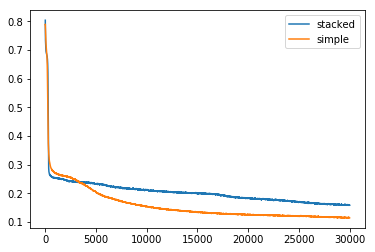

Final loss: 0.15823662


In [22]:
plt.plot(smear(loss_vals_1, WINDOW_SIZE), label='stacked')
plt.plot(smear(loss_vals_0, WINDOW_SIZE), label='simple')  # as comparison.
plt.legend()
plt.show()
print('Final loss:', np.mean(loss_vals_1[-WINDOW_SIZE:]))

And let's zoom in the first severl steps (without smearing)

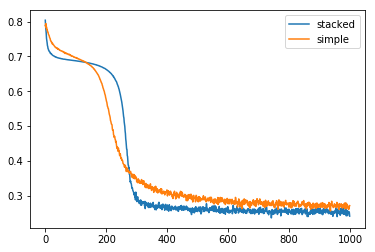

In [23]:
plt.plot(loss_vals_1[:1000], label='stacked')
plt.plot(loss_vals_0[:1000], label='simple')  # as comparison.
plt.legend()
plt.show()

In [24]:
sess.close()

* Comparing with the simple auto-encoder, the stacked auto-encoder cannot get a smaller loss, even though having a much greater representability.

* If we have infinite resource and time, we would expect that the loss of the stacked can finally be smaller than that of the simple one. But the problem is how to make it smaller when we only have finite resource and time, which, after all, is the very reality.

#### Non-efficiency of Training Deeper Model

Thus, we have encountered the big problem of training deeper model: the non-efficiency (and further, the instability).

Since the first layer is randomly initialized, the information of data cannot be passed to the following layers without being greatly lost. And since the second layer is randomly initialized, the information of data cannot be passed to the following layers without being greatly lost. E.t.c. This mechanism delays the cooperation between the layers, which is expected as the most important feature of a deeper model would benefit.

The non-efficiency also brings instability. Randomness in the forward propagation causes the randomness in the backward. The updation of variables in the backward propagation, then, cannot be surely stable.

## Solution

There have been several solutions to this problem. Like the [highway or residual structure](http://www.cs.toronto.edu/~fidler/teaching/2015/slides/CSC2523/renjie_highwayNNs.pdf) of network. Herein we employ the strategy of reusing pre-training sub-graph.

Indeed, if we reuse the pre-trained sub-graph in the first several layers, then the information can be passed into the following layers, which thus will be efficiently trained (in this stage of training, the pre-trained variables are fixed). And once the information can be passed through the whole model, we train the model (in this stage, all variables in the model) for enhancing the cooperation bewteen layers, lighlighting the great power of deeper model.

In the following, we will show how to reuse pre-trained sub-graph in _TensorFlow_, which is quite straight-forward.

This implementation is also for transfer-learning.

### Stacked Auto-encoder with Pre-training

In [25]:
tf.reset_default_graph()

In [26]:
X_ph = tf.placeholder(shape=[None, 28*28], dtype='float32', name='X')

In [27]:
encoded_0 = deep_nn(X_ph, [512, 256], name='encoder_0')
encoded_1 = deep_nn(encoded_0, [128, 64], name='encoder_1')
decoded_1 = deep_nn(encoded_1, [128, 256], name='decoder_1')
decoded_0 = deep_nn(decoded_1, [512, 28*28], name='decoder_0')

In [28]:
loss = tf.losses.sigmoid_cross_entropy(X_ph, decoded_0)

In [29]:
optimizer = tf.train.AdamOptimizer(epsilon=1e-3)
train_op = optimizer.minimize(loss)

In [30]:
def is_pretrained(variable):
    """
    Args:
        variable: An instance of `tf.Variable`.
        
    Returns:
        Boolean.
    """
    if variable.name.startswith('encoder_0'):
        return True
    if variable.name.startswith('decoder_0'):
        return True
    return False

vars_without_pretrained = [var for var in get_dependent_variables(loss)
                           if not is_pretrained(var)]
train_op_pretrained = optimizer.minimize(
    loss, var_list=vars_without_pretrained)

In [31]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [32]:
restore_variables(sess, 'encoder_0', SAVE_DIR)
restore_variables(sess, 'decoder_0', SAVE_DIR)

INFO:tensorflow:Restoring parameters from ./dat/checkpoints/encoder_0_scope.ckpt
INFO:tensorflow:Restoring parameters from ./dat/checkpoints/decoder_0_scope.ckpt


We train the model by fixing the pre-trained variables for the first 1/5 iterations, and then finish the rest iterations without any fixing.

In [33]:
# With the pre-trained being fixed.

loss_vals_2 = []

for step in trange(int(N_ITERS/5)):
    X_batch = get_X_batch(BATCH_SIZE)
    _, loss_val = sess.run([train_op_pretrained, loss], {X_ph: X_batch})
    loss_vals_2.append(loss_val)

100%|██████████| 6000/6000 [01:04<00:00, 93.05it/s] 


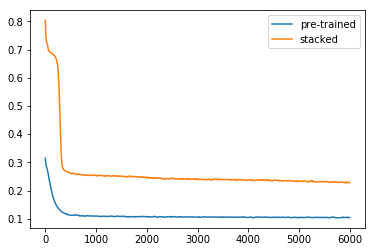

Middle loss: 0.10416974


In [34]:
# Plot the middle stage for comparison

plt.plot(smear(loss_vals_2, WINDOW_SIZE), label='pre-trained')
plt.plot(smear(loss_vals_1[:len(loss_vals_2)], WINDOW_SIZE),
         label='stacked')
plt.legend()
plt.show()
print('Middle loss:', np.mean(loss_vals_2[-WINDOW_SIZE:]))

In [35]:
# Without any fixing.

for step in trange(int(N_ITERS/5*4)):
    X_batch = get_X_batch(BATCH_SIZE)
    _, loss_val = sess.run([train_op, loss], {X_ph: X_batch})
    loss_vals_2.append(loss_val)

100%|██████████| 24000/24000 [06:30<00:00, 61.87it/s]


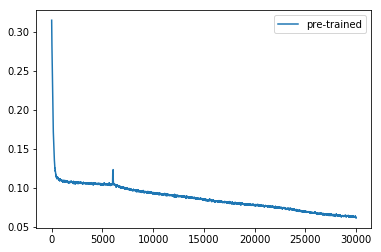

Final loss: 0.061530095


In [36]:
plt.plot(smear(loss_vals_2, WINDOW_SIZE), label='pre-trained')
plt.legend()
plt.show()
print('Final loss:', np.mean(loss_vals_2[-WINDOW_SIZE:]))

In [37]:
sess.close()

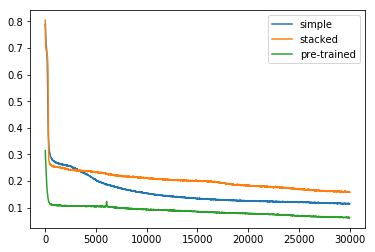

In [38]:
# Comparison

plt.plot(smear(loss_vals_0, WINDOW_SIZE), label='simple')
plt.plot(smear(loss_vals_1, WINDOW_SIZE), label='stacked')
plt.plot(smear(loss_vals_2, WINDOW_SIZE), label='pre-trained')
plt.legend()
plt.show()

The one with pre-training wins, as expected.